<a href="https://colab.research.google.com/github/manoharvenkatesh3/SparkComplex/blob/master/sales_data_AIQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import required libraries
import pandas as pd
import requests
import sqlalchemy
import os

# Set up API keys as environment variables
os.environ['OPENWEATHERMAP_API_KEY'] = 'e9005334bb02cbfd470051804f3f731d'

In [5]:
import pandas as pd

# Load the sales data CSV file into a pandas DataFrame
sales_df = pd.read_csv('/content/sample_data/sales_data.csv')

# Convert order_id, customer_id, and product_id columns to integers
sales_df.dtypes[['order_id']] = int
sales_df.dtypes[['customer_id']] = int
sales_df.dtypes[['product_id']] = int

# Convert quantity and price columns to floats
#sales_df[['quantity']] = pd.to_float64(sales_df['quantity'])
#sales_df[['price']] = pd.to_float64(sales_df['price'])
sales_df.dtypes['quantity'] = float
sales_df.dtypes['price'] = float

# Convert order_date column to datetime format
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'])

# Handle missing values in quantity and price columns
sales_df.fillna(0, inplace=True)

# Drop rows with missing values in order_id, customer_id, or product_id columns
sales_df.dropna(subset=['order_id', 'customer_id', 'product_id'], inplace=True)

# Print the cleaned and preprocessed DataFrame
print(sales_df)

     order_id  customer_id  product_id  quantity  price order_date
0        2334            5          40         3  35.60 2022-06-21
1        6228            8          13         7  36.52 2023-03-08
2        7784            9          44         4  46.56 2023-04-22
3        6588            5          26         1  15.87 2022-10-23
4        5910            8          32        10  77.00 2022-10-05
..        ...          ...         ...       ...    ...        ...
995      7967            6          34        10  14.44 2022-07-26
996      8308            6          16         1  61.38 2023-03-04
997      6938            4          18         7  62.96 2022-11-27
998      5921            9          37         9  52.89 2022-09-22
999      8395            4          16         7  46.09 2022-06-10

[1000 rows x 6 columns]


In [6]:
# Define a function to fetch user data from the JSONPlaceholder API
def fetch_user_data(user_ids):
    url = 'https://jsonplaceholder.typicode.com/users'
    response = requests.get(url, params={'ids': ','.join(map(str, user_ids))})
    user_data = response.json()
    return user_data

# Extract relevant fields and merge user data with sales data
user_ids = sales_df['customer_id'].unique()
user_data = fetch_user_data(user_ids)
user_sales_df = pd.json_normalize(user_data)[['id', 'name', 'username', 'email', 'address.geo.lat', 'address.geo.lng']]
merged_df = pd.merge(sales_df, user_sales_df, left_on='customer_id', right_on='id', how='left')
merged_df = merged_df.rename(columns={'price':'sales_amount','quantity':'order_quantity','address.geo.lat':'lat','address.geo.lng':'lon'})
print(merged_df)

     order_id  customer_id  product_id  order_quantity  sales_amount  \
0        2334            5          40               3         35.60   
1        6228            8          13               7         36.52   
2        7784            9          44               4         46.56   
3        6588            5          26               1         15.87   
4        5910            8          32              10         77.00   
..        ...          ...         ...             ...           ...   
995      7967            6          34              10         14.44   
996      8308            6          16               1         61.38   
997      6938            4          18               7         62.96   
998      5921            9          37               9         52.89   
999      8395            4          16               7         46.09   

    order_date  id                      name          username  \
0   2022-06-21   5          Chelsey Dietrich            Kamren   
1  

In [7]:
import json
import requests

def get_weather_data(lat, lon):
    api_key = os.getenv('OPENWEATHERMAP_API_KEY')
    url = f'https://api.openweathermap.org/data/2.5/weather'
    params = {'lat': lat, 'lon': lon, 'appid': api_key, 'units': 'metric'}
    response = requests.get(url, params=params)
    weather_data = response.json()
    return weather_data

def extract_weather_info(weather_data):
    weather_info = {
        'temperature': weather_data['main']['temp'],
        'conditions': weather_data['weather'][0]['description']
    }
    return weather_info

# Assuming merged_df has 'lat' and 'lon' columns
# Add weather data
merged_df['weather_data'] = merged_df.apply(lambda row: extract_weather_info(get_weather_data(row['lat'], row['lon'])), axis=1)
print(merged_df)

     order_id  customer_id  product_id  order_quantity  sales_amount  \
0        2334            5          40               3         35.60   
1        6228            8          13               7         36.52   
2        7784            9          44               4         46.56   
3        6588            5          26               1         15.87   
4        5910            8          32              10         77.00   
..        ...          ...         ...             ...           ...   
995      7967            6          34              10         14.44   
996      8308            6          16               1         61.38   
997      6938            4          18               7         62.96   
998      5921            9          37               9         52.89   
999      8395            4          16               7         46.09   

    order_date  id                      name          username  \
0   2022-06-21   5          Chelsey Dietrich            Kamren   
1  

In [9]:
!pip install pyodbc
import sqlalchemy
import pyodbc
# Calculate total sales amount per customer
customer_sales = merged_df.groupby(['customer_id','name'])['sales_amount'].sum().reset_index()
customer_sales.columns = ['customer_id','Customer_Name','Total_sales_amt_per_customer']
print("Total Sales Amount Per Customer:")
print(customer_sales)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.7/334.7 kB 6.5 MB/s eta 0:00:00
Total Sales Amount Per Customer:
   customer_id             Customer_Name  Total_sales_amt_per_customer
0            1             Leanne Graham                       4307.43
1            2              Ervin Howell                       5948.32
2            3          Clementine Bauch                       5391.75
3            4          Patricia Lebsack                       5144.84
4            5          Chelsey Dietrich                       5801.88
5            6      Mrs. Dennis Schulist                       5411.82
6            7           Kurtis Weissnat                       4934.06
7            8  Nicholas Runolfsdottir V                       5891.11
8            9           Glenna Reichert                       6142.81
9           10        Clementina DuBuque                       6067.06


"!pip install pymysql\nimport pymysql\nimport pandas as pd\ncustomer_sales = merged_df.groupby(['customer_id','name'])['sales_amount'].sum().reset_index()\ncustomer_sales.columns = ['customer_id','Customer Name','Total_sales_amt_per_customer']\nconnection = pymysql.connect(\n    host='localhost',\n    user='root',\n    password='test123',\n    db='sales_schema'\n)\ncustomer_sales.to_sql('mytable', connection, if_exists='replace', index=False)\n"

In [11]:
# Creating customer_sales table in SQLite Environment
import sqlite3
conn = sqlite3.connect('sales_analytics_database.db')
customer_sales.to_sql('customer_sales', conn, if_exists='replace', index=False)
result = pd.read_sql_query('SELECT * FROM customer_sales', conn)
print(result)
table_definition = conn.execute('PRAGMA table_info(customer_sales)')
for row in table_definition:
    print(row)
conn.close()

   customer_id             Customer_Name  Total_sales_amt_per_customer
0            1             Leanne Graham                       4307.43
1            2              Ervin Howell                       5948.32
2            3          Clementine Bauch                       5391.75
3            4          Patricia Lebsack                       5144.84
4            5          Chelsey Dietrich                       5801.88
5            6      Mrs. Dennis Schulist                       5411.82
6            7           Kurtis Weissnat                       4934.06
7            8  Nicholas Runolfsdottir V                       5891.11
8            9           Glenna Reichert                       6142.81
9           10        Clementina DuBuque                       6067.06
(0, 'customer_id', 'INTEGER', 0, None, 0)
(1, 'Customer_Name', 'TEXT', 0, None, 0)
(2, 'Total_sales_amt_per_customer', 'REAL', 0, None, 0)


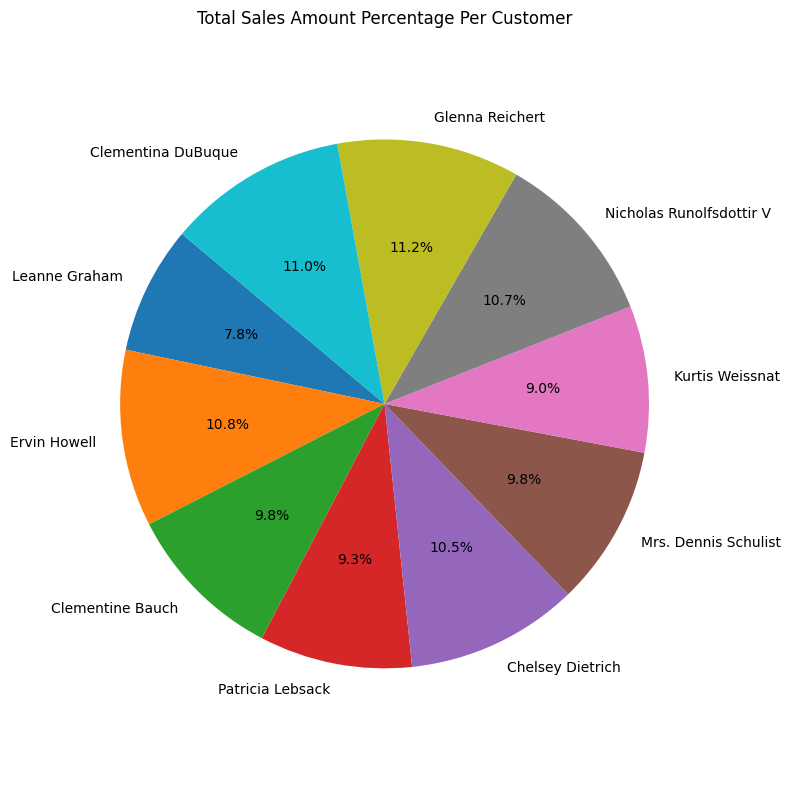

In [31]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(customer_sales['Customer_Name'], customer_sales['Total_sales_amt_per_customer'])
plt.xlabel('Customer Name')
plt.ylabel('Total Sales Amount')
plt.title('Total Sales Amount Per Customer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(customer_sales['Total_sales_amt_per_customer'], labels=customer_sales['Customer_Name'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Total Sales Amount Percentage Per Customer')
plt.tight_layout()
plt.show()



In [12]:
# Determine the average order quantity per product
product_quantity = merged_df.groupby(['customer_id','product_id'])['order_quantity'].mean().reset_index()
product_quantity.columns = ['customer_id','product_id', 'avg_order_quantity']

print('Average Order Quantity per Product:')
print(product_quantity.head(100))


Average Order Quantity per Product:
    customer_id  product_id  avg_order_quantity
0             1           2            7.250000
1             1           3            9.000000
2             1           4            7.000000
3             1           5            5.000000
4             1           6            4.500000
..          ...         ...                 ...
95            3          12            5.500000
96            3          13            3.666667
97            3          14            4.000000
98            3          15            6.500000
99            3          16           10.000000

[100 rows x 3 columns]


In [13]:
# Creating Average_product_quantity table in SQLite Environment
conn = sqlite3.connect('sales_analytics_database.db')
product_quantity.to_sql('Average_product_quantity', conn, if_exists='replace', index=False)
result = pd.read_sql_query('SELECT * FROM Average_product_quantity', conn)
print(result)
table_definition = conn.execute('PRAGMA table_info(Average_product_quantity)')
for row in table_definition:
    print(row)
conn.close()

     customer_id  product_id  avg_order_quantity
0              1           2                7.25
1              1           3                9.00
2              1           4                7.00
3              1           5                5.00
4              1           6                4.50
..           ...         ...                 ...
431           10          46                2.50
432           10          47                4.00
433           10          48                7.00
434           10          49                4.00
435           10          50                8.00

[436 rows x 3 columns]
(0, 'customer_id', 'INTEGER', 0, None, 0)
(1, 'product_id', 'INTEGER', 0, None, 0)
(2, 'avg_order_quantity', 'REAL', 0, None, 0)


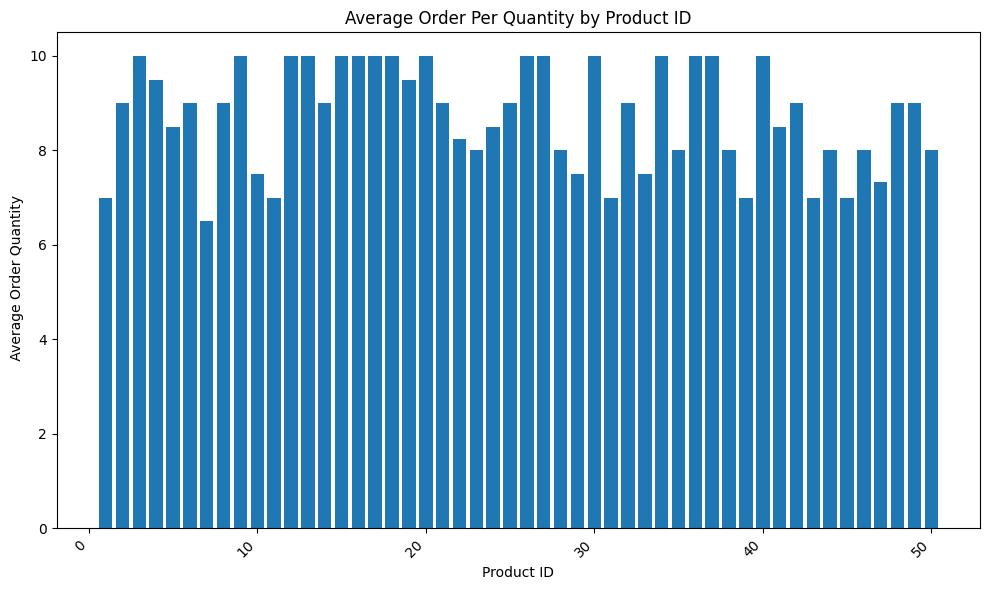

In [30]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(product_quantity['product_id'], product_quantity['avg_order_quantity'])
plt.xlabel('Product ID')
plt.ylabel(' Average Order Quantity')
plt.title('Average Order Per Quantity by Product ID')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [14]:
# Identify the top-selling products and customers
top_sellers = merged_df.groupby(['product_id', 'customer_id'])['sales_amount'].sum().reset_index()
top_sellers = top_sellers.rename(columns={'sales_amount': 'total_sales_prod_by_cust'})
top_sellers = top_sellers.sort_values('total_sales_prod_by_cust', ascending=False)

# Identify the top 5 customers based on total sales
top_customers = customer_sales.nlargest(5, columns=['Total_sales_amt_per_customer'])

# Identify the top 5 products based on total sales
top_products = top_sellers.nlargest(5, columns=['total_sales_prod_by_cust'])

# Print the top customers and products
print("Top Customers:")
print(top_customers)
print("\nTop Products:")
print(top_products)




Top Customers:
   customer_id             Customer_Name  Total_sales_amt_per_customer
8            9           Glenna Reichert                       6142.81
9           10        Clementina DuBuque                       6067.06
1            2              Ervin Howell                       5948.32
7            8  Nicholas Runolfsdottir V                       5891.11
4            5          Chelsey Dietrich                       5801.88

Top Products:
     product_id  customer_id  total_sales_prod_by_cust
321          37            4                    477.46
204          23            9                    414.84
97           11            9                    384.72
158          18            8                    381.10
135          15           10                    380.66


In [15]:
# Creating Top_Customers table in SQLite Environment
conn = sqlite3.connect('sales_analytics_database.db')
top_customers.to_sql('Top_Customers', conn, if_exists='replace', index=False)
result = pd.read_sql_query('SELECT * FROM Top_Customers', conn)
print(result)
table_definition = conn.execute('PRAGMA table_info(Top_Customers)')
for row in table_definition:
    print(row)
conn.close()

   customer_id             Customer_Name  Total_sales_amt_per_customer
0            9           Glenna Reichert                       6142.81
1           10        Clementina DuBuque                       6067.06
2            2              Ervin Howell                       5948.32
3            8  Nicholas Runolfsdottir V                       5891.11
4            5          Chelsey Dietrich                       5801.88
(0, 'customer_id', 'INTEGER', 0, None, 0)
(1, 'Customer_Name', 'TEXT', 0, None, 0)
(2, 'Total_sales_amt_per_customer', 'REAL', 0, None, 0)


In [16]:
# Creating Top_Products table in SQLite Environment
conn = sqlite3.connect('sales_analytics_database.db')
top_products.to_sql('Top_Products', conn, if_exists='replace', index=False)
result = pd.read_sql_query('SELECT * FROM Top_Products', conn)
print(result)
table_definition = conn.execute('PRAGMA table_info(Top_Products)')
for row in table_definition:
    print(row)
conn.close()

   product_id  customer_id  total_sales_prod_by_cust
0          37            4                    477.46
1          23            9                    414.84
2          11            9                    384.72
3          18            8                    381.10
4          15           10                    380.66
(0, 'product_id', 'INTEGER', 0, None, 0)
(1, 'customer_id', 'INTEGER', 0, None, 0)
(2, 'total_sales_prod_by_cust', 'REAL', 0, None, 0)


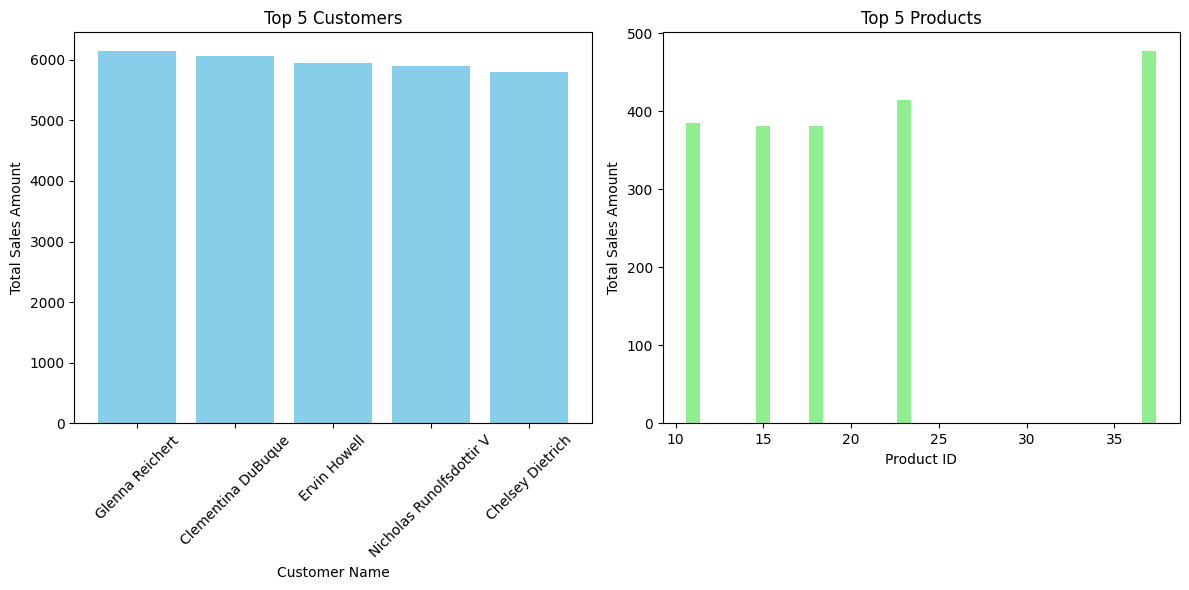

In [32]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for top customers
axes[0].bar(top_customers['Customer_Name'], top_customers['Total_sales_amt_per_customer'], color='skyblue')
axes[0].set_title('Top 5 Customers')
axes[0].set_xlabel('Customer Name')
axes[0].set_ylabel('Total Sales Amount')

# Rotate x-axis labels for better readability
axes[0].tick_params(axis='x', rotation=45)

# Bar plot for top products
axes[1].bar(top_products['product_id'], top_products['total_sales_prod_by_cust'], color='lightgreen')
axes[1].set_title('Top 5 Products')
axes[1].set_xlabel('Product ID')
axes[1].set_ylabel('Total Sales Amount')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plots
plt.show()


In [17]:
# Analyze sales trends over time
# Convert 'order_date' column to datetime
merged_df['order_date'] = pd.to_datetime(merged_df['order_date'])

# Group by month and calculate sales trends
month_sales_trends = merged_df.groupby(pd.Grouper(key='order_date', freq='M'))['sales_amount'].sum().reset_index()
print('Month_sales_trends:')
print(month_sales_trends)

# Group by Quaterly and calculate sales trends
Quarterly_sales_trends = merged_df.groupby(pd.Grouper(key='order_date', freq='Q'))['sales_amount'].sum().reset_index()
print('\nQuarterly_sales_trends:')
print(Quarterly_sales_trends)


Month_sales_trends:
   order_date  sales_amount
0  2022-06-30       4307.08
1  2022-07-31       4657.21
2  2022-08-31       4329.40
3  2022-09-30       4830.47
4  2022-10-31       4896.04
5  2022-11-30       4056.54
6  2022-12-31       4833.86
7  2023-01-31       4385.75
8  2023-02-28       4621.22
9  2023-03-31       4656.20
10 2023-04-30       4980.59
11 2023-05-31       4350.19
12 2023-06-30        136.53

Quarterly_sales_trends:
  order_date  sales_amount
0 2022-06-30       4307.08
1 2022-09-30      13817.08
2 2022-12-31      13786.44
3 2023-03-31      13663.17
4 2023-06-30       9467.31


In [18]:
# Creating Month_Sales_Trend table in SQLite Environment
conn = sqlite3.connect('sales_analytics_database.db')
month_sales_trends.to_sql('Month_Sales_Trend', conn, if_exists='replace', index=False)
result = pd.read_sql_query('SELECT * FROM Month_Sales_Trend', conn)
print(result)
table_definition = conn.execute('PRAGMA table_info(Month_Sales_Trend)')
for row in table_definition:
    print(row)
conn.close()

             order_date  sales_amount
0   2022-06-30 00:00:00       4307.08
1   2022-07-31 00:00:00       4657.21
2   2022-08-31 00:00:00       4329.40
3   2022-09-30 00:00:00       4830.47
4   2022-10-31 00:00:00       4896.04
5   2022-11-30 00:00:00       4056.54
6   2022-12-31 00:00:00       4833.86
7   2023-01-31 00:00:00       4385.75
8   2023-02-28 00:00:00       4621.22
9   2023-03-31 00:00:00       4656.20
10  2023-04-30 00:00:00       4980.59
11  2023-05-31 00:00:00       4350.19
12  2023-06-30 00:00:00        136.53
(0, 'order_date', 'TIMESTAMP', 0, None, 0)
(1, 'sales_amount', 'REAL', 0, None, 0)


In [19]:
# Creating Quarterly_Sales table in SQLite Environment
conn = sqlite3.connect('sales_analytics_database.db')
Quarterly_sales_trends.to_sql('Quarterly_Sales', conn, if_exists='replace', index=False)
result = pd.read_sql_query('SELECT * FROM Quarterly_Sales', conn)
print(result)
table_definition = conn.execute('PRAGMA table_info(Quarterly_Sales)')
for row in table_definition:
    print(row)
conn.close()

            order_date  sales_amount
0  2022-06-30 00:00:00       4307.08
1  2022-09-30 00:00:00      13817.08
2  2022-12-31 00:00:00      13786.44
3  2023-03-31 00:00:00      13663.17
4  2023-06-30 00:00:00       9467.31
(0, 'order_date', 'TIMESTAMP', 0, None, 0)
(1, 'sales_amount', 'REAL', 0, None, 0)


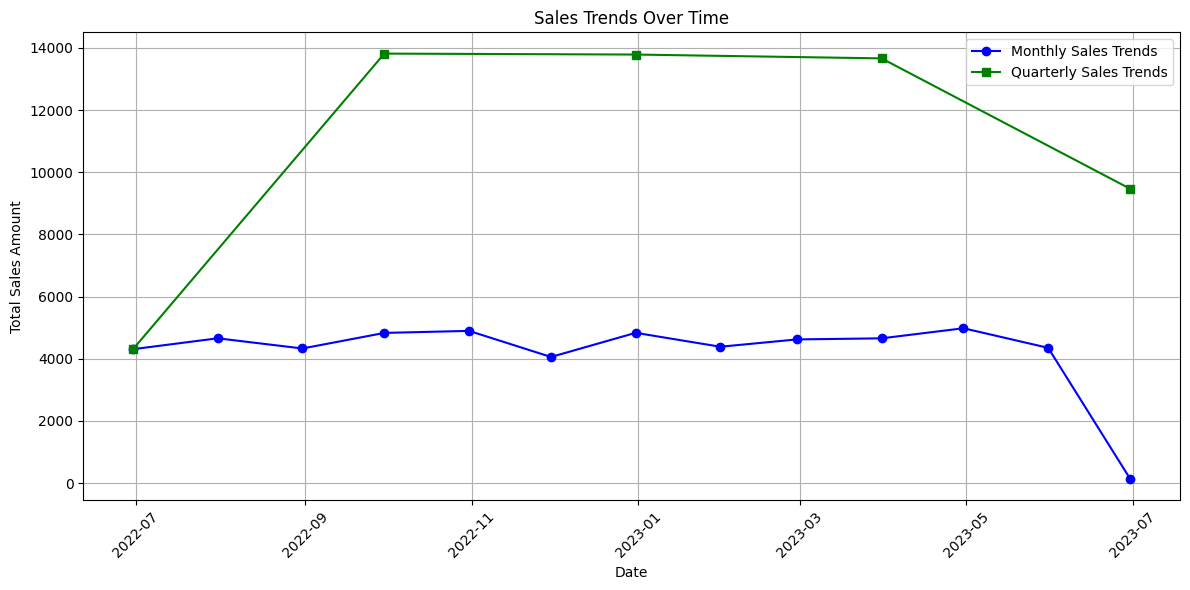

In [33]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot monthly sales trends
plt.plot(month_sales_trends['order_date'], month_sales_trends['sales_amount'], marker='o', color='blue', label='Monthly Sales Trends')

# Plot quarterly sales trends
plt.plot(Quarterly_sales_trends['order_date'], Quarterly_sales_trends['sales_amount'], marker='s', color='green', label='Quarterly Sales Trends')

# Set titles and labels
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')

# Add a legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
# Include weather data in the analysis
weather_conditions = merged_df['weather_data'].apply(lambda x: x['conditions']).value_counts()
print(weather_conditions)
avg_sales_by_condition = merged_df.groupby(merged_df['weather_data'].apply(lambda x: x['conditions']))['sales_amount'].mean().reset_index()
avg_sales_by_condition.columns = ['weather_condition', 'avg_sales']
print(avg_sales_by_condition)


overcast clouds    416
broken clouds      205
clear sky          198
light rain         181
Name: weather_data, dtype: int64
  weather_condition  avg_sales
0     broken clouds  55.415317
1         clear sky  55.943788
2        light rain  55.852541
3   overcast clouds  54.073942


In [40]:
# Creating Avg_Sales_Weather table in SQLite Environment
conn = sqlite3.connect('sales_analytics_database.db')
avg_sales_by_condition.to_sql('Avg_Sales_Weather', conn, if_exists='replace', index=False)
result = pd.read_sql_query('SELECT * FROM Avg_Sales_Weather', conn)
print(result)
table_definition = conn.execute('PRAGMA table_info(Avg_Sales_Weather)')
for row in table_definition:
    print(row)
conn.close()

  weather_condition  avg_sales
0     broken clouds  55.415317
1         clear sky  55.943788
2        light rain  55.852541
3   overcast clouds  54.073942
(0, 'weather_condition', 'TEXT', 0, None, 0)
(1, 'avg_sales', 'REAL', 0, None, 0)


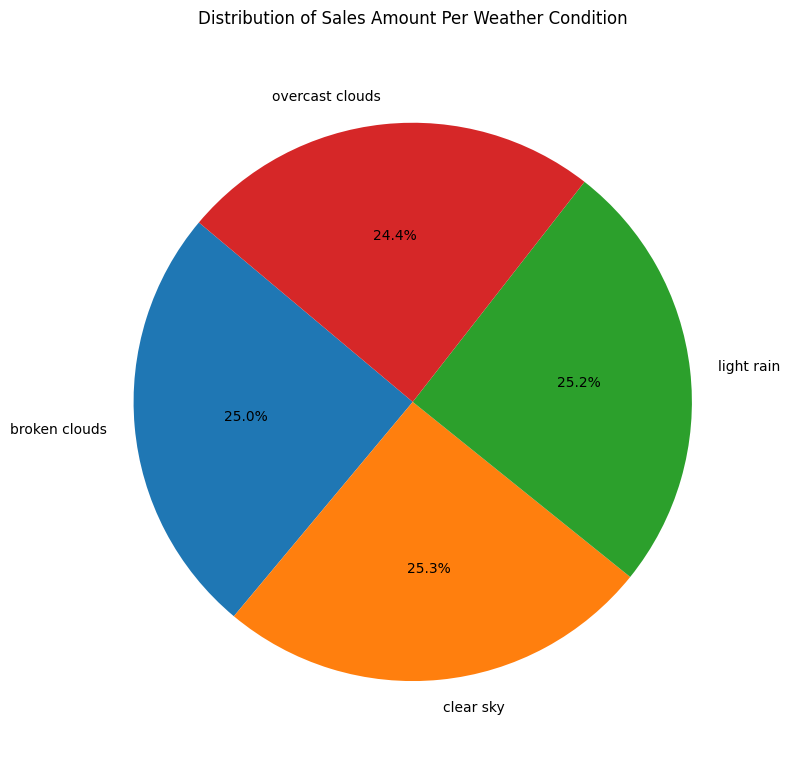

In [41]:
# Pie chart: Distribution of Sales Amount Per Weather Condition
plt.figure(figsize=(8, 8))
plt.pie(avg_sales_by_condition['avg_sales'], labels=avg_sales_by_condition['weather_condition'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Sales Amount Per Weather Condition')
plt.tight_layout()